## Trends in programming languages and licences

In [4]:
import os
import subprocess
import datetime
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.sql import functions as F

from pyspark.sql.types import *

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [5]:
# import pyspark functions and data types
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, ArrayType, DoubleType, BooleanType
from pyspark.sql.functions import col, element_at, count, countDistinct, avg, split, array_contains, isnan, when

In [1]:
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

In [2]:
gcs_folder = 'gs://msca-bdp-students-bucket/shared_data/esmyslovskikh/whole_df.parquet/'

df = spark.read \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .parquet(gcs_folder)

In [6]:
df = df.withColumn("commit_time", col("commit_time").cast("timestamp"))
df = df.withColumn("commit_day", split(df["commit_time"], " ")[0])
# year column
df = df.withColumn("commit_year", split(df["commit_day"], "-")[0])
#df = df.withColumn("commit_time", col("commit_time").cast("int"))
df = df.withColumn("commit_year", col("commit_year").cast(IntegerType()))
#df.cache()

In [7]:
df = df.filter((df['commit_day'] >= '2008-01-01') & (df['commit_day'] <= '2023-01-01'))

In [12]:
grouped_committers = df.groupby('commit_author').agg(count('*')).orderBy('count(1)', ascending=False)
grouped_committers = grouped_committers.limit(20).toPandas()

In [14]:
most_popular_committers = list(grouped_committers['commit_author'])[:18]
most_popular_committers

['GitHub',
 'CI Pool Resource',
 'NetKAN inflator Robot',
 'Gerrit Code Review',
 'Sarah Singer',
 'CI Pool Trigger Resource',
 'Marvel Explorer',
 'Commit Bot',
 "Matthew Weier O'Phinney",
 'Commit bot',
 'Facebook GitHub Bot',
 'Emilien Kenler',
 'Facebook Github Bot',
 'Dmitriy Zaporozhets',
 'Salvatore Iovene',
 'Android Git Automerger',
 'Peter Donald',
 'Zeno Rogue']

In [16]:
df_grouped_a = df.groupby('commit_author').agg(count('*'))
df_grouped_a = df_grouped_a.filter(df_grouped_a.commit_author.isin(most_popular_committers))
df_grouped_a = df_grouped_a.withColumn("count(1)", col("count(1)").cast(IntegerType()))
df_grouped_a = df_grouped_a.toPandas()
df_grouped_a = df_grouped_a.rename({"count(1)": "Commits", "commit_author": "Committer"}, axis=1)
df_grouped_a

,Committer,Commits
0,Facebook Github Bot,1473
1,Peter Donald,1149
2,Android Git Automerger,1185
3,NetKAN inflator Robot,5953
4,Gerrit Code Review,5269
5,Salvatore Iovene,1232
6,CI Pool Trigger Resource,3754
7,GitHub,92398
8,Sarah Singer,3797
9,Dmitriy Zaporozhets,1360


In [17]:
# Import seaborn
import seaborn as sns

# Apply the default theme
sns.set_theme(style="darkgrid")

<AxesSubplot:xlabel='Commits', ylabel='Committer'>

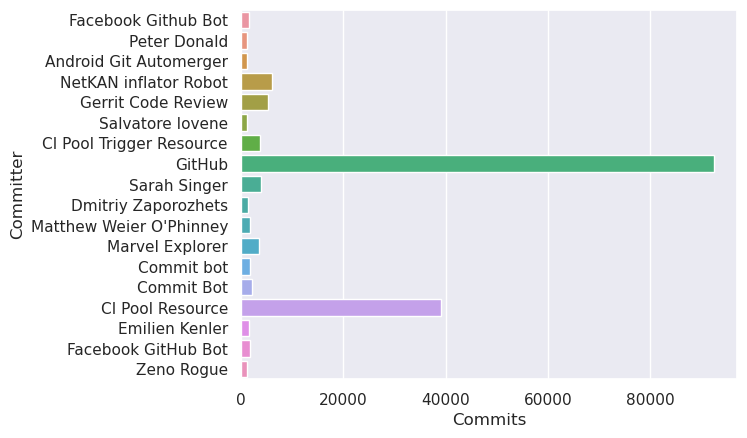

In [21]:
sns.barplot(y="Committer", x="Commits",
             #hue="Language",
             data=df_grouped_a)

## What are the most frequent reasons for committing into GitHub repositories?

In [7]:
from pyspark.sql.functions import monotonically_increasing_id

In [8]:
from pyspark.ml.feature import StopWordsRemover, CountVectorizer

In [9]:
# Add an 'id' column to df: the IDs are not necessarily consecutive but are guaranteed to be unique across the entire DataFrame.
df_text = df.withColumn("id", monotonically_increasing_id())

# Split text into words
df_text = df_text.withColumn("words", split(col("subject"), " "))

# Remove punctuation and split into words
df_text = df_text.withColumn("clean_text", F.regexp_replace(F.col("subject"), "[^a-zA-Z0-9\\s]", ""))
df_text = df_text.withColumn("words", split(F.col("clean_text"), " "))

# Filter out tokens that are less than 3 characters
df_text = df_text.withColumn("clean_words", F.expr("filter(words, word -> length(word) >= 3)"))

# Remove stopwords
remover = StopWordsRemover(inputCol="clean_words", outputCol="filtered_words")
df_text = remover.transform(df_text)

display(df_text.select('id',
                       'subject',
                       'clean_text',
                       'words',
                       'clean_words',
                       'filtered_words').limit(5).toPandas())

# Keep only the variables we need
df_text = df_text.select('id','subject','filtered_words')

,id,subject,clean_text,words,clean_words,filtered_words
0,0,triggering build with pending triggers: 0; pending removals: 6,triggering build with pending triggers 0 pending removals 6,"[triggering, build, with, pending, triggers, 0, pending, removals, 6]","[triggering, build, with, pending, triggers, pending, removals]","[triggering, build, pending, triggers, pending, removals]"
1,1,esquire: use the proper function when loading the theme language files. See #2859,esquire use the proper function when loading the theme language files See 2859,"[esquire, use, the, proper, function, when, loading, the, theme, language, files, See, 2859]","[esquire, use, the, proper, function, when, loading, the, theme, language, files, See, 2859]","[esquire, use, proper, function, loading, theme, language, files, See, 2859]"
2,2,triggering build with pending triggers: 0; pending removals: 1,triggering build with pending triggers 0 pending removals 1,"[triggering, build, with, pending, triggers, 0, pending, removals, 1]","[triggering, build, with, pending, triggers, pending, removals]","[triggering, build, pending, triggers, pending, removals]"
3,3,[Automated] [koi] New translations,Automated koi New translations,"[Automated, koi, New, translations]","[Automated, koi, New, translations]","[Automated, koi, New, translations]"
4,4,[packages] bluelog: update to 1.0.4,packages bluelog update to 104,"[packages, bluelog, update, to, 104]","[packages, bluelog, update, 104]","[packages, bluelog, update, 104]"


In [10]:
#vectorize = CountVectorizer(inputCol="filtered_words", outputCol="features", minDF=1.0)
#df_vectorize = vectorize.fit(df_text).transform(df_text)

In [11]:
import pyspark.sql.functions as f
from operator import add
from pyspark.ml.feature import Tokenizer
from pyspark.ml.feature import StopWordsRemover

In [16]:
df_grouped_s = df.groupby('subject').agg(count('*')).orderBy("count(1)", ascending=False)
df_grouped_s

subject,count(1)
Update README.md,12499
Initial commit,9284
,3176
a,2086
Add files via upload,1971
update,1896
b,1863
triggering build ...,1689
Merge remote-trac...,1096
Update index.html,1072


In [20]:
df_grouped_s = df_grouped_s.toPandas()

,subject,count(1)
0,Update README.md,12499
1,Initial commit,9284
2,,3176
3,a,2086
4,Add files via upload,1971
...,...,...
1055038,main/cf-for-k8s-main/run-cats build 330 adding unclaimed: addictive-memory,1
1055039,main/cf-deployment/fresh-acquire-pool build 142 claiming: luna,1
1055040,Fixes #33014 - Sync pulpcore capsules after promote (#9475),1
1055041,main/k8s-pool-management/create-cluster build 13307 removing: comforting-memory,1


In [24]:
df_grouped_s.head(70)

,subject,count(1)
0,Update README.md,12499
1,Initial commit,9284
2,,3176
3,a,2086
4,Add files via upload,1971
5,update,1896
6,b,1863
7,triggering build with pending triggers: 0; pending removals: 1,1689
8,Merge remote-tracking branch 'origin/master',1096
9,Update index.html,1072


In [12]:
df_text.withColumn('filtered_words', f.explode(f.split(f.col('subject'), ' '))) \
  .groupBy('filtered_words') \
  .count() \
  .sort('count', ascending=False) \
  .show()

+--------------+------+
|filtered_words| count|
+--------------+------+
|            to|209447|
|           for|124739|
|           the|123896|
|         Merge|122125|
|          from|107786|
|           and| 93610|
|            of| 93256|
|            in| 92664|
|              | 67996|
|       request| 67624|
|          pull| 65763|
|        Update| 62680|
|           Add| 59568|
|             a| 57900|
|         build| 52549|
|        branch| 47922|
|          with| 42785|
|           Fix| 42468|
|             -| 42294|
|            on| 41230|
+--------------+------+
only showing top 20 rows



In [13]:
tokenizer = Tokenizer(inputCol="subject", outputCol="words_token")
tokenized = tokenizer.transform(df_text).select('id','words_token')

print('############ Tokenized data extract:')
#tokenized.show()

# Once in arrays, we can use the Apache Spark function StopWordsRemover
# A new column "words_clean" is here as an output
remover = StopWordsRemover(inputCol='words_token', outputCol='words_clean')
data_clean = remover.transform(tokenized).select('id', 'words_clean')

print('############ Data Cleaning extract:')
#data_clean.show()

# Final step : like in the beginning, we can group again words and sort them by the most used
result = data_clean.withColumn('word', f.explode(f.col('words_clean'))) \
  .groupBy('word') \
  .count().sort('count', ascending=False) \

print('############ TOP20 Most used words in subject of commits are:')
result.show(40)

############ Tokenized data extract:
############ Data Cleaning extract:
############ TOP20 Most used words in subject of commits are:


+-----------+------+
|       word| count|
+-----------+------+
|      merge|127547|
|        add| 98072|
|     update| 94290|
|        fix| 81588|
|           | 69364|
|      added| 69099|
|    request| 67838|
|       pull| 65971|
|      build| 53677|
|     branch| 47987|
|          -| 42476|
|      fixed| 35139|
|     remove| 31147|
|        use| 29183|
|    updated| 28227|
|    version| 27731|
|       test| 27263|
|        new| 26998|
|   'master'| 20461|
|     commit| 19533|
|       code| 18573|
|    support| 18245|
|     adding| 18163|
|       file| 18141|
|      tests| 17520|
|    initial| 17464|
|  claiming:| 16998|
|  readme.md| 16440|
|      files| 15418|
|      fixes| 15251|
|    removed| 15075|
|     readme| 14246|
|     change| 14239|
|       make| 13990|
|        bug| 13606|
|       bump| 12907|
|  bellatrix| 12773|
|      error| 12437|
|unclaiming:| 11720|
|    changes| 11096|
+-----------+------+
only showing top 40 rows

